## Recommender system for beauty products

Recommender systems are straightforward algorithms that select the most relevant and accurate information for the user from a sizable information source. By studying consumer preferences, recommendation engines find patterns in the data set and provide results that are relevant to their wants and needs.

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import random


### Loading the dataset

In [3]:
data = pd.read_csv('ratings_Beauty.csv')

In [4]:
data

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200


### Attribute Information

- UserId: every user is identified and alloted with a unique id
- ProductId: every product is assigned a unique product id
- Rating: depicts the rating of a product given by the corresponding user
- Timestamp: time at which the rating was given

### Data Exploration


In [5]:
data.shape

(2023070, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [7]:
data.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [8]:
data.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [9]:
data.UserId.nunique()

1210271

In [10]:
data.ProductId.nunique()

249274

<AxesSubplot: xlabel='Rating', ylabel='count'>

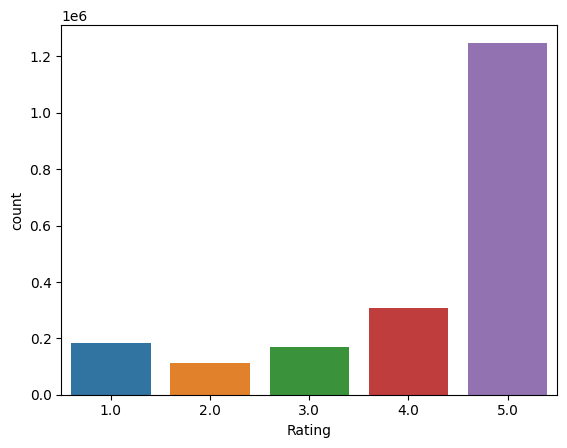

In [11]:
sns.countplot(x='Rating',data=data)

In [15]:
product_ratings = data.groupby('ProductId')['Rating'].count()
product_ratings.sort_values(ascending=False)

ProductId
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
              ... 
B004U81OBC       1
B004U7R0EI       1
B004U7Q2O2       1
B004U7NKRE       1
B00LU0LTOU       1
Name: Rating, Length: 249274, dtype: int64

In [16]:
user_ratings = data.groupby('UserId')['Rating'].count().sort_values(ascending = False)

In [17]:
user_ratings

UserId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
A2G8M8PDTN09UZ      1
A2G8MAFIIQSJ42      1
A2G8MTKRE6MV52      1
A2G8MWBXG6JIY6      1
AZZZU2TD7Q3ET       1
Name: Rating, Length: 1210271, dtype: int64

In [20]:
len(data[data.Rating==5]['ProductId'].unique())

200831

In [22]:
print('Number of users who rate 5 on products:',len(data[data['Rating']==5]['UserId'].unique()))
print('Number of users who rate 4 on products:',len(data[data['Rating']==4]['UserId'].unique()))
print('Number of users who rate 3 on products:',len(data[data['Rating']==3]['UserId'].unique()))
print('Number of users who rate 2 on products:',len(data[data['Rating']==2]['UserId'].unique()))
print('Number of users who rate 1 on products:',len(data[data['Rating']==1]['UserId'].unique()))

Number of users who rate 5 on products: 824697
Number of users who rate 4 on products: 238261
Number of users who rate 3 on products: 140097
Number of users who rate 2 on products: 99470
Number of users who rate 1 on products: 162401


In [23]:
rating = pd.DataFrame(data.groupby('ProductId')['Rating'].mean().sort_values(ascending=False))

In [25]:
rating['number of ratings'] = pd.DataFrame(data.groupby('ProductId')['Rating'].count().sort_values(ascending=False))

In [28]:
rating.sort_values('number of ratings',ascending=False)

,Rating,number of ratings
ProductId,,
B001MA0QY2,4.321386,7533
B0009V1YR8,3.568839,2869
B0043OYFKU,4.310456,2477
B0000YUXI0,4.405040,2143
B003V265QW,4.365421,2088
...,...,...
B0013H228W,5.000000,1
B0013GNAIE,5.000000,1
B0013GNAG6,5.000000,1


<AxesSubplot: xlabel='ProductId'>

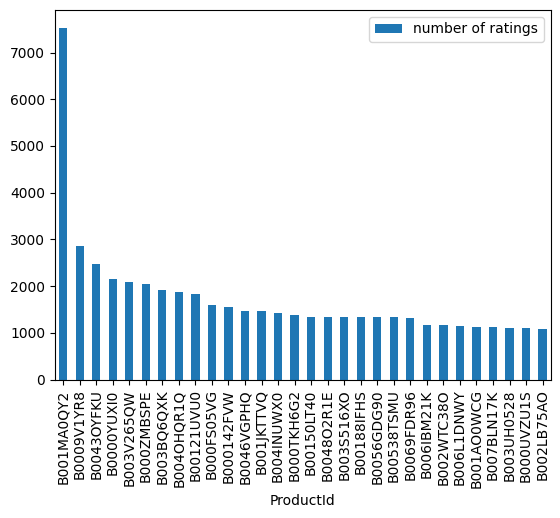

In [30]:
rating[['number of ratings']].sort_values('number of ratings',ascending=False).head(30).plot(kind = 'bar')

### Collaborative filtering approach

Recommender systems frequently use collaborative filtering. These methods seek to complete a user-item association matrix's missing entries. We'll employ a collaborative filtering (CF) strategy. The foundation of CF is the notion that recommendations from people with similar tastes are always the best. In other words, it predicts how someone would rank an item by using past item ratings from like people.

In [44]:
new_df = data.groupby('ProductId').filter(lambda x: x['Rating'].count()>=50)

In [45]:
new_df

,UserId,ProductId,Rating,Timestamp
1705,A2SR9M2CWC2OCP,9790790961,4.0,1379894400
1706,A3V1EVBYP0U77W,9790790961,2.0,1397606400
1707,AVJKKAS4P52P9,9790790961,5.0,1404432000
1708,A2NQQDBBGFW1OT,9790790961,5.0,1390694400
1709,A1OFNEUHZ7BSCB,9790790961,5.0,1392336000
...,...,...,...,...
2022803,A2EIA53X91F8J,B00L5JHZJO,5.0,1399939200
2022804,A1MDF6GJDANUTH,B00L5JHZJO,5.0,1404604800
2022805,A3T20TGEE4OPB5,B00L5JHZJO,5.0,1400716800
2022806,A2MCFN2F0IINLY,B00L5JHZJO,5.0,1399939200


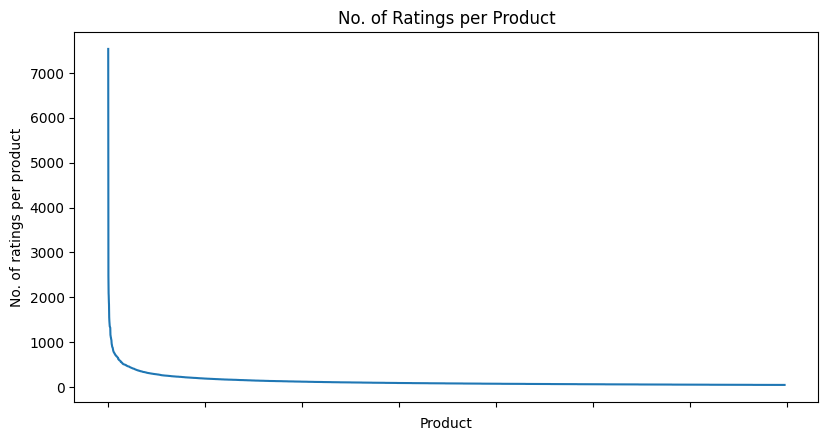

In [48]:
no_of_ratings_per_product = new_df.groupby(by='ProductId')['Rating'].count().sort_values(ascending=False)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('No. of Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No. of ratings per product')
ax.set_xticklabels([])
plt.show()

In [33]:
ratings_df = data.head(15000)

In [34]:
ratings_utility_matrix = ratings_df.pivot_table(values='Rating',index = 'UserId',columns='ProductId',fill_value=0)

In [35]:
ratings_utility_matrix

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B0000535AW,B0000535B4,B0000535BD,B0000535CH,B0000535EM,B0000535EO,B0000535OF,B0000535QU,B0000535QX,B0000535RA
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00473363TJ8YSZ3YAGG9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZHJZP4GQPPZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZNK89PXD006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZOFVMQC0BJG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
ratings_utility_matrix.shape

(14410, 1178)

In [38]:
t_ratings_utility_matrix = ratings_utility_matrix.T

In [39]:
t_ratings_utility_matrix

UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A06298653TJ91G7R7MD6R,A065995424G4KBBX1V8BO,...,AZYQEFB9Y5N22,AZZ5ENX41WOYZ,AZZ8A0TEQOD7J,AZZDA9BRMPP1B,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0000535EO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000535OF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000535QU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(t_ratings_utility_matrix)

In [43]:
decomposed_matrix.shape

(1178, 10)

In [57]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix

array([[ 1.        ,  0.79710428, -0.7471673 , ...,  0.32405563,
         0.34794793,  0.33590954],
       [ 0.79710428,  1.        , -0.77096986, ...,  0.75065979,
         0.01808838,  0.83009101],
       [-0.7471673 , -0.77096986,  1.        , ..., -0.25773501,
         0.09906033, -0.54088403],
       ...,
       [ 0.32405563,  0.75065979, -0.25773501, ...,  1.        ,
        -0.26573099,  0.85986359],
       [ 0.34794793,  0.01808838,  0.09906033, ..., -0.26573099,
         1.        , -0.32145519],
       [ 0.33590954,  0.83009101, -0.54088403, ...,  0.85986359,
        -0.32145519,  1.        ]])

In [58]:
correlation_matrix.shape

(1178, 1178)

In [60]:
# choosing any random index
y = random.randint(0,correlation_matrix.shape[0])
y

576

In [62]:
productId = t_ratings_utility_matrix.index[y]
productId

'979079651X'

In [63]:
correlated_productIds = correlation_matrix[y]
correlated_productIds

array([ 0.54561187,  0.78498068, -0.92914186, ...,  0.42381504,
       -0.33419688,  0.74487645])

In [64]:
recommended_products = t_ratings_utility_matrix[correlated_productIds>0.90]
recommended_products= list(recommended_products)

In [65]:
# top 10 recommended products for the product chosen using a random index
recommended_products[0:10]

['A00205921JHJK5X9LNP42',
 'A00473363TJ8YSZ3YAGG9',
 'A024581134CV80ZBLIZTZ',
 'A03056581JJIOL5FSKJY7',
 'A03099101ZRK4K607JVHH',
 'A0505229A7NSH3FRXRR4',
 'A05492663T95KW63BR75K',
 'A059547920Q3LZVFHLPI3',
 'A06298653TJ91G7R7MD6R',
 'A065995424G4KBBX1V8BO']